### Download dataset

In [1]:
import os
import shared.data_utils as data_utils
import torch
from torch.utils.data import Dataset, DataLoader
import json
from tqdm import tqdm
import joblib

In [3]:
import joblib 

# Get all .obj file paths in dataset
def foo(dir_path):
    if dir_path.endswith('models'):
        with open(os.path.join(dir_path, 'model_normalized.json'), 'r') as f:
            num_verts = json.load(f)['numVertices']
            if num_verts > 800:
                return
        return os.path.join(dir_path, 'model_normalized.obj')

# get all obj paths in paralllel
obj_paths = joblib.Parallel(n_jobs=-1)(joblib.delayed(foo)(dir_path) for (dir_path, dir_names, file_names) in os.walk('./chairs_and_benches'))
obj_paths = [x for x in obj_paths if x is not None]


In [22]:
dataset = f'./processed_chairs_and_benches/'

# Get all .obj file paths in dataset
def foo(i, dir_path):
    if dir_path.endswith('models'):
        with open(os.path.join(dir_path, 'model_normalized.json'), 'r') as f:
            num_verts = json.load(f)['numVertices']
            if num_verts > 800:
                return
            obj_path = os.path.join(dir_path, 'model_normalized.obj')
            mesh_dict = data_utils.load_process_mesh(obj_path)
            # Mesh is too large
            if len(mesh_dict['faces']) > 2800:
                return

            mesh_dict['vertices'] = torch.tensor(mesh_dict['vertices'])
            mesh_dict['faces'] = torch.tensor(mesh_dict['faces'])

            os.makedirs(os.path.join(dataset, f'model_{i}'), exist_ok=True)
            torch.save(mesh_dict, os.path.join(dataset, f'model_{i}', 'processed_model.pt'))
        return (obj_path, f'model_{i}') #os.path.join(dir_path, 'model_normalized.obj')
    
# get all obj paths in paralllel
obj_paths = joblib.Parallel(n_jobs=-1)(joblib.delayed(foo)(i, dir_path) for i, (dir_path, dir_names, file_names) in enumerate(os.walk('./chairs_and_benches')))
obj_paths = [x for x in obj_paths if x is not None]

In [3]:
print(len(obj_paths))

2128


In [2]:
import os
import shared.data_utils as data_utils
import torch
from torch.utils.data import Dataset, DataLoader
import json
from tqdm import tqdm
import pickle

""" with open("filtered_by_num_verts_800", "wb") as fp:   #Pickling
    pickle.dump(obj_paths, fp) """
with open("filtered_by_num_verts_800", "rb") as fp:   # Unpickling
    obj_paths = pickle.load(fp)

In [3]:
import math
import bpy
import random
from mathutils import Vector
import os
import numpy as np


def generate_images_random_environment(model_path, save_file_path, n_variations=50):
    # camera distance from object
    camera_min_distance = 1.25
    camera_max_distance = 1.5
    working_dir = os.getcwd()

    bpy.ops.wm.read_homefile(use_empty=True)
    model = model_path.split('\\')[-1].split('.')[0]
    bpy.ops.import_scene.obj(filepath=model_path, filter_glob="*.obj;*.mtl") # filter_glob="*.obj;*.mtl" to include materials
    #bpy.ops.import_scene.obj(filepath=model_path)
    base_object = bpy.data.objects[model]

    def scale_on_diag():
        # Calculate the current diagonal length of the bounding box
        object_length = math.sqrt(base_object.dimensions.x ** 2 + base_object.dimensions.y ** 2)
        # Calculate the scale factor to achieve a diagonal length of 1
        scale_factor = 1.0 / object_length
        # Scale the object uniformly using the calculated scale factor
        base_object.scale.x *= scale_factor
        base_object.scale.y *= scale_factor
        base_object.scale.z *= scale_factor

    scale_on_diag()

    # The below code is good for creating multiple meshes out of one mesh, but I am only using one mesh per model
    """ # axis scaling
    sx, sy, sz = (random.uniform(0.75, 1.25), random.uniform(0.75, 1.25), random.uniform(0.75, 1.25))
    base_object.scale.x *= sx
    base_object.scale.y *= sy
    base_object.scale.z *= sz
    scale_on_diag() # scale on diagonal after every scaling operation

    # piecewise linear warping
    scale_on_diag()

    # planar mesh decimation
    modifier=base_object.modifiers.new("DecimateMod",'DECIMATE')
    modifier.angle_limit = np.deg2rad(random.uniform(0,20))
    modifier.use_collapse_triangulate=True
    scale_on_diag() 
    """
    
    bpy.data.worlds.new("World")
    bpy.ops.scene.new(type='NEW')
    bpy.context.scene.world = bpy.data.worlds.get("World")
    bpy.context.scene.world.use_nodes = True
    

    bpy.ops.object.camera_add(enter_editmode=False, align='VIEW', location=(0, 0, 0), rotation=(0, 0, 0))
    camera = bpy.context.object
    # Set the camera as the active camera in the scene
    bpy.context.scene.camera = camera
    # Add a "Track To" constraint to make the camera point at the object
    camera_track_to_constraint = camera.constraints.new('TRACK_TO')

    bpy.ops.object.light_add(type='AREA', location=(0, 0, 1.5))
    light = bpy.context.object
    light.data.energy = 20
    light.data.size = 2.5
    light_track_to_constraint = light.constraints.new('TRACK_TO')
    

    bpy.context.scene.render.resolution_x = 256
    bpy.context.scene.render.resolution_y = 256
    bpy.context.scene.render.image_settings.file_format = 'PNG'
    
    for i in range(n_variations):
        # Set the background color to a random color
        #r, g, b, a = random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)
        #bpy.context.scene.world.node_tree.nodes['Background'].inputs['Color'].default_value = (r, g, b, a)
        
        # n random 15W spot lights 
        n_point_light = random.randint(0, 10)
        for _ in range(n_point_light):
            bpy.ops.object.light_add(type='POINT', location=(random.uniform(-2, 0.75), random.uniform(-0.75, 2), random.uniform(0.75, 2)))
            light = bpy.context.object
            light.data.energy = 15
            light_track_to_constraint = light.constraints.new('TRACK_TO')
            light_track_to_constraint.target = base_object

        # Create a copy of the base object for each variation
        variation_object = base_object.copy()
        bpy.context.collection.objects.link(variation_object)

        """ # Set unique materials for the model (you need to define your materials)
        material = bpy.data.materials.new(name="Material") 
        material.use_nodes = True
        material.node_tree.nodes.clear()

        # Create the Node Tree
        nodes = material.node_tree.nodes

        # Add a Material Output, then any other nodes you want
        output = nodes.new(type='ShaderNodeOutputMaterial')

        color_ramp = nodes.new(type='ShaderNodeValToRGB')
        color_ramp.color_ramp.interpolation = 'LINEAR'  # You can change the interpolation method.
        color_ramp.color_ramp.elements[0].position = 0.0  # Start of the gradient.
        color_ramp.color_ramp.elements[1].position = 1.0  # End of the gradient.
        
        # Add color points to the color ramp and set their colors.
        color_point1 = color_ramp.color_ramp.elements.new(0)  # Position at 0% of the ramp
        color_point1.color = (random.uniform(0,1.0), random.uniform(0,1.0), random.uniform(0,1.0), 1.0) # Set the color to red (R, G, B, A)

        color_point2 = color_ramp.color_ramp.elements.new(1.0)  # Position at 100% of the ramp
        color_point2.color = (1.0, 1.0, 1.0, 1.0) 

        color_point3 = color_ramp.color_ramp.elements.new(0.5)  # Position at 50% of the ramp
        color_point3.color = (random.uniform(0,1.0), random.uniform(0,1.0), random.uniform(0,1.0), 1.0) """

        """ 
        # More random colours
        # assigning location
        color_ramp.color_ramp.hue_interpolation = 'FAR'
        color_ramp.color_ramp.color_mode = 'HSV'

        # Create 3 colour steps
        p = [random.uniform(0, 1), random.uniform(0, 1),random.uniform(0, 1)]
        p.sort()
        p1,p2,p3 = p[0],p[1],p[2]
        
        # Colour steps for red, green and blue
        # two steps are already created by default
        color_ramp.color_ramp.elements[0].position = p1
        color_ramp.color_ramp.elements[0].color = (1,0,0,1)

        # create a new stop
        color_ramp.color_ramp.elements.new(p2)
        color_ramp.color_ramp.elements[1].color = (0,1, 0,1)

        color_ramp.color_ramp.elements[2].position = p3
        color_ramp.color_ramp.elements[2].color = (0,0,1,1) """

        """ # Add a Principled BSDF Shader, and adjust some values
        bsdf = nodes.new(type='ShaderNodeBsdfPrincipled')
        # Set the Roughness
        bsdf.inputs[9].default_value = random.uniform(0, 1)
        # Set the Metallic
        bsdf.inputs[6].default_value = random.uniform(0, 1)
    
        # Add a Noise Texture Node
        noise = nodes.new(type='ShaderNodeTexNoise')
        # Increase the Scale
        #noise.inputs[2].default_value = random.uniform(0, 10)
        noise.inputs[2].default_value = math.sqrt(100 * random.uniform(0, 1))
        # Detail
        noise.inputs[3].default_value = 16

        # Now to connect the nodes
        links = material.node_tree.links
        # Create a connection between the Noise Texture and the Color Ramp
        links.new(noise.outputs[0], color_ramp.inputs[0])
        # Create a connection between the Color Ramp and the Principled BSDF
        links.new(color_ramp.outputs[0], bsdf.inputs[0])
        # Create a connection between the first output of the Principled BSDF and 
        # the first input of the Material Output
        links.new(bsdf.outputs[0], output.inputs[0])
        
        variation_object.data.materials.clear()
        variation_object.data.materials.append(material) """

        # Camera
        camera_track_to_constraint.target = variation_object
        # Randomize camera position, rotation is always looking at the object
        elevation = random.uniform(0, 1)
        dist = random.uniform(camera_min_distance, camera_max_distance)
        rot = random.randint(0, 360) # rotation around object
        camera.location = Vector([dist, dist, elevation])
        camera.location.x *= math.cos(np.deg2rad(rot)) # convert rot to vector and scale distance
        camera.location.y *= math.sin(np.deg2rad(rot))
        #camera.rotation_euler = Vector([0, 0, np.deg2rad(rot)])
        focal_len = random.randint(35, 50)
        camera.data.lens = focal_len
  
        # Light
        light_track_to_constraint.target = variation_object
        light.location = camera.location + Vector([random.uniform(-5, 5), random.uniform(-5, 5), random.uniform(-5, 5)])

        # Render
        bpy.context.scene.render.filepath = os.path.join(working_dir, save_file_path, f'var_{i}.png')
        bpy.context.scene.render.filter_size = random.uniform(1.5, 2) # small random blur
        # Render the image
        bpy.ops.render.render(write_still=True)

        # Save the blend file
        #bpy.ops.wm.save_as_mainfile(filepath=f'variation_{i}.blend')

    #joblib.Parallel(n_jobs=-1)(joblib.delayed(create_variation)(i) for i in range(n_variations))
#joblib.Parallel(n_jobs=-1)(joblib.delayed(generate_images_random_environment)(i) for i in range(n_variations))
#generate_images_random_environment(obj_paths[0], f'./processed_dataset/model_{1}', n_variations=20)


In [4]:
import math
import bpy
import random
from mathutils import Vector
import os
import numpy as np


def generate_images(model_paths, save_base_path, n_variations=50):
    # camera distance from object
    camera_min_distance = 1.25
    camera_max_distance = 1.5
    working_dir = os.getcwd()

    bpy.ops.wm.read_homefile(use_empty=True)
    bpy.data.worlds.new("World")
    bpy.ops.scene.new(type='NEW')
    bpy.context.scene.world = bpy.data.worlds.get("World")
    bpy.context.scene.world.use_nodes = True

    bpy.ops.object.light_add(type='AREA', location=(0, 0, 1.5))
    light = bpy.context.object
    light.data.energy = 20
    light.data.size = 2.5
    light_track_to_constraint = light.constraints.new('TRACK_TO')

    bpy.ops.object.camera_add(enter_editmode=False, align='VIEW', location=(0, 0, 0), rotation=(0, 0, 0))
    camera = bpy.context.object
    # Set the camera as the active camera in the scene
    bpy.context.scene.camera = camera
    # Add a "Track To" constraint to make the camera point at the object
    camera_track_to_constraint = camera.constraints.new('TRACK_TO')

    bpy.context.scene.render.resolution_x = 128
    bpy.context.scene.render.resolution_y = 128
    bpy.context.scene.render.image_settings.file_format = 'PNG'

    def clear_point_lights():
        # Iterate over all objects in the scene
        for obj in bpy.data.objects:
            # Check if the object is a point light
            if (obj.type == 'LIGHT' and obj.data.type == 'POINT'):
                # Delete the point light
                bpy.data.objects.remove(obj)

    for (model_path, model_name) in tqdm(model_paths):
        model = model_path.split('\\')[-1].split('.')[0]
        bpy.ops.import_scene.obj(filepath=model_path, filter_glob="*.obj;*.mtl") # filter_glob="*.obj;*.mtl" to include materials
        #bpy.ops.import_scene.obj(filepath=model_path)
        base_object = bpy.data.objects[model]

        camera_track_to_constraint.target = base_object

        def scale_on_diag():
            # Calculate the current diagonal length of the bounding box
            object_length = math.sqrt(base_object.dimensions.x ** 2 + base_object.dimensions.y ** 2)
            # Calculate the scale factor to achieve a diagonal length of 1
            scale_factor = 1.0 / object_length
            # Scale the object uniformly using the calculated scale factor
            base_object.scale.x *= scale_factor
            base_object.scale.y *= scale_factor
            base_object.scale.z *= scale_factor

        scale_on_diag()

        # The below code is good for creating multiple meshes out of one mesh, but I am only using one mesh per model
        """ # axis scaling
        sx, sy, sz = (random.uniform(0.75, 1.25), random.uniform(0.75, 1.25), random.uniform(0.75, 1.25))
        base_object.scale.x *= sx
        base_object.scale.y *= sy
        base_object.scale.z *= sz
        scale_on_diag() # scale on diagonal after every scaling operation

        # piecewise linear warping
        scale_on_diag()

        # planar mesh decimation
        modifier=base_object.modifiers.new("DecimateMod",'DECIMATE')
        modifier.angle_limit = np.deg2rad(random.uniform(0,20))
        modifier.use_collapse_triangulate=True
        scale_on_diag() 
        """
        
        
        save_file_path = os.path.join(save_base_path, model_name)
        for i in range(n_variations):
            # Set the background color to a random color
            #r, g, b, a = random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)
            #bpy.context.scene.world.node_tree.nodes['Background'].inputs['Color'].default_value = (r, g, b, a)
            
            # n random 15W spot lights 
            n_point_light = random.randint(0, 10)
            for _ in range(n_point_light):
                bpy.ops.object.light_add(type='POINT', location=(random.uniform(-2, 0.75), random.uniform(-0.75, 2), random.uniform(0.75, 2)))
                light = bpy.context.object
                light.data.energy = 15
                light_track_to_constraint = light.constraints.new('TRACK_TO')
                light_track_to_constraint.target = base_object

            # Create a copy of the base object for each variation
            #variation_object = base_object.copy()
            #bpy.context.collection.objects.link(variation_object)

            # Camera
            #camera_track_to_constraint.target = variation_object
            # Randomize camera position, rotation is always looking at the object
            elevation = random.uniform(0, 1)
            dist = random.uniform(camera_min_distance, camera_max_distance)
            rot = random.randint(0, 360) # rotation around object
            camera.location = Vector([dist, dist, elevation])
            camera.location.x *= math.cos(np.deg2rad(rot)) # convert rot to vector and scale distance
            camera.location.y *= math.sin(np.deg2rad(rot))
            #camera.rotation_euler = Vector([0, 0, np.deg2rad(rot)])
            focal_len = random.randint(35, 50)
            camera.data.lens = focal_len
    
            # Light
            #light_track_to_constraint.target = variation_object
            #light.location = camera.location + Vector([random.uniform(-5, 5), random.uniform(-5, 5), random.uniform(-5, 5)])

            # Render
            
            bpy.context.scene.render.filepath = os.path.join(working_dir, save_file_path, f'var_{i}.png')
            bpy.context.scene.render.filter_size = random.uniform(1.5, 2) # small random blur
            # Render the image
            bpy.ops.render.render(write_still=True)

            clear_point_lights()

            # Save the blend file
            #bpy.ops.wm.save_as_mainfile(filepath=f'variation_{i}.blend')
        #mesh = bpy.data.meshes["Cube"]
        bpy.data.meshes.remove(base_object.data)
        #bpy.data.objects.remove(base_object, do_unlink=True)
        
        # item='MESH'
        # bpy.ops.object.select_all(action='DESELECT')
        # bpy.ops.object.select_by_type(type=item)
        # bpy.ops.object.delete()
        



In [5]:
from tqdm import tqdm
import importlib
importlib.reload(data_utils)
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


#dataset = f'./processed_dataset_orig_broken_textures/'
#dataset = f'./processed_dataset_orig_broken_textures/'
        
dataset = f'./processed_chairs_and_benches/'

""" def preprocess_dataset(obj_path, i):
    #obj_path, i = args
    mesh_dict = data_utils.load_process_mesh(obj_path)
    # Mesh is too large
    if len(mesh_dict['vertices']) > 800 or len(mesh_dict['faces']) > 2800:
        return False

    #mesh_dict['class_label'] = torch.tensor(k)
    mesh_dict['vertices'] = torch.tensor(mesh_dict['vertices'])
    mesh_dict['faces'] = torch.tensor(mesh_dict['faces'])

    os.makedirs(os.path.join(dataset, f'model_{i}'), exist_ok=True)
    torch.save(mesh_dict, os.path.join(dataset, f'model_{i}', 'processed_model.pt'))
    generate_images_random_environment(obj_path, os.path.join(dataset, f'model_{i}'), n_variations=10)
    return True """



curr_model = 0
saved_models = 0
os.makedirs(dataset, exist_ok=True)


with HiddenPrints(): # blender prints render info to stdout, may run out of memory if running for hours
    generate_images(obj_paths, dataset, n_variations=10)

#print([dir_names for (dir_path, dir_names, file_names) in os.walk('./processed_chairs_and_benches')])

""" for i in tqdm(range(len(obj_paths))):
    with HiddenPrints(): # blender prints render info to stdout, may run out of memory if running for hours
        generate_images(obj_paths, dataset, n_variations=10) """

""" if preprocess_dataset(obj_paths[i], saved_models):
    saved_models += 1 """



  0%|          | 0/2128 [00:00<?, ?it/s]

100%|██████████| 2128/2128 [2:33:05<00:00,  4.32s/it]  


' if preprocess_dataset(obj_paths[i], saved_models):\n    saved_models += 1 '

### Rename model directories in order

In [6]:
import shutil, os
from tqdm import tqdm
import torch

# rename files in order
#saved_models = 10000 # SAVE all files with high numbers first then start from zero again
saved_models = 0
dataset = './processed_chairs_and_benches/'
files = next(os.walk(dataset))[1]
n_files = len(files)
path = "C:/Users/charl/Documents/polygen/processed_chairs_and_benches"
for file_name in tqdm(files):
    #try:
    os.rename(os.path.join(path, file_name), os.path.join(path, f"model_{saved_models}"))
    """ except:
        print("ERROR")
        pass """
    saved_models += 1

  0%|          | 0/2128 [00:00<?, ?it/s]

  3%|▎         | 60/2128 [00:00<00:03, 593.52it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


  8%|▊         | 167/2128 [00:00<00:04, 401.28it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 10%|▉         | 212/2128 [00:00<00:05, 373.19it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 15%|█▌        | 323/2128 [00:00<00:03, 461.62it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 20%|█▉        | 420/2128 [00:00<00:03, 457.31it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 25%|██▍       | 531/2128 [00:01<00:03, 468.75it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 30%|██▉       | 632/2128 [00:01<00:03, 486.63it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 36%|███▋      | 775/2128 [00:01<00:02, 595.38it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 42%|████▏     | 901/2128 [00:01<00:02, 492.09it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 45%|████▍     | 955/2128 [00:01<00:02, 496.57it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 54%|█████▎    | 1141/2128 [00:02<00:01, 577.33it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 60%|██████    | 1285/2128 [00:02<00:01, 649.70it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 67%|██████▋   | 1435/2128 [00:02<00:00, 705.77it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 74%|███████▍  | 1578/2128 [00:02<00:00, 703.19it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 77%|███████▋  | 1649/2128 [00:03<00:00, 640.57it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 83%|████████▎ | 1776/2128 [00:03<00:00, 586.53it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 90%|████████▉ | 1905/2128 [00:03<00:00, 616.24it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


 95%|█████████▌| 2032/2128 [00:03<00:00, 572.52it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


100%|██████████| 2128/2128 [00:03<00:00, 558.20it/s]

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


### Rename model directories in order

In [ ]:
import shutil, os
from tqdm import tqdm
import torch

saved_models = 0
files = next(os.walk('./reduced_similar_mesh_dataset'))[1]
n_files = len(files)
path = "C:/Users/charl/OneDrive/Documents/University/Computer Science/PROJECT/Polygen-Pytorch/reduced_similar_mesh_dataset"
for i in tqdm(range(n_files)):
    model = torch.load(f'./reduced_similar_mesh_dataset/model_{i}/processed_model.pt')
    if model['vertices'].shape[0] > 800 or model['faces'].shape[0] > 2800:
        shutil.rmtree(os.path.join(path, f"model_{i}"))
    else:
        try:
            os.rename(os.path.join(path, f"model_{i}"), os.path.join(path, f"model_{saved_models}"))
        except:
            pass
        saved_models += 1

In [1]:
# CHECK FOR ALL ZERO VERTICES
import torch, os
from tqdm import tqdm
files = next(os.walk('./reduced_similar_mesh_dataset'))[1]
n_files = len(files)
c = 0
for i in tqdm(range(n_files)):
    model = torch.load(f'./reduced_similar_mesh_dataset/model_{i}/processed_model.pt')
    if (model['vertices'] == 0).all() or (model['faces'] == 0).all():
        c += 1
print(c)

100%|██████████| 2313/2313 [00:21<00:00, 108.58it/s]

0


### Max num of verts and faces in dataset

In [16]:
import torch, os
from tqdm import tqdm
files = next(os.walk('./reduced_similar_mesh_dataset'))[1]
n_files = len(files)
max_v, max_f = 0, 0
for i in tqdm(range(n_files)):
    model = torch.load(f'./reduced_similar_mesh_dataset/model_{i}/processed_model.pt')
    if model['vertices'].shape[0] > max_v:
        max_v = model['vertices'].shape[0]
    if model['faces'].shape[0] > max_f:
        max_f = model['faces'].shape[0]
print(max_v, max_f)

  0%|          | 0/2313 [00:00<?, ?it/s]

100%|██████████| 2313/2313 [00:17<00:00, 132.38it/s]

409 2800


### Display mesh from dataset

/tmp/ipykernel_82671/299546490.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  {'vertices': torch.tensor(shape['vertices']),
/tmp/ipykernel_82671/299546490.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})


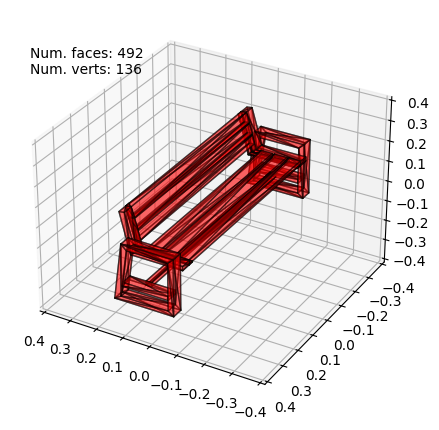

tensor([ 78,  14, 101,  78,  14, 156,  78,  25, 101,  78,  25, 156,  78, 231,
        101,  78, 231, 156,  78, 242, 101,  78, 242, 156,  83,  14, 106,  83,
         14, 150,  83,  25, 106,  83,  25, 150,  83, 231, 106,  83, 231, 150,
         83, 242, 106,  83, 242, 150,  96,  14, 106,  96,  14, 149,  96,  25,
        106,  96,  25, 128,  96,  25, 133,  96,  25, 149,  96, 231, 106,  96,
        231, 128,  96, 231, 133,  96, 231, 149,  96, 242, 106,  96, 242, 149,
        101,  14, 106, 101,  14, 148, 101,  25, 106, 101,  25, 128, 101,  25,
        133, 101,  25, 148, 101, 231, 106, 101, 231, 128, 101, 231, 133, 101,
        231, 148, 101, 242, 106, 101, 242, 148, 128,  25,  99, 128,  25, 147,
        128,  35,  99, 128,  35, 147, 128,  40,  99, 128,  40, 147, 128, 216,
         99, 128, 216, 147, 128, 221,  99, 128, 221, 147, 128, 231,  99, 128,
        231, 147, 129,  35,  99, 129,  35, 110, 129,  35, 112, 129,  35, 124,
        129,  35, 126, 129,  35, 137, 129,  35, 146, 129,  40,  

/tmp/ipykernel_82671/299546490.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(shape['vertices_flat']))


In [5]:
import torch
from shared import data_utils
# Plot the meshes
mesh_list = []
#for shape in synthetic_dataset:
#shape = torch.load(f'./reduced_similar_mesh_dataset/model_2312/processed_model.pt')
shape = torch.load(f'./processed_chairs_and_benches/model_0/processed_model.pt')
#print(data_utils.quantize_verts(torch.tensor(shape['vertices'])))
mesh_list.append(
    {'vertices': torch.tensor(shape['vertices']),
      'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})
data_utils.plot_meshes(mesh_list, ax_lims=0.4, vert_size=0.1)


print(torch.tensor(shape['vertices_flat']))

In [ ]:
""" objs = bpy.data.objects
    objs.remove(objs["Cube"], do_unlink=True)

    if not os.path.exists('./dataset'):
        os.makedirs('./dataset')

    working_dir = os.getcwd()

    # Replace 'your_model.obj' with the path to your 3D model file
    model = 'cone'
    bpy.ops.import_scene.obj(filepath=os.path.join(working_dir, 'meshes', f'{model}.obj'))

    # Reference the imported object
    base_object = bpy.data.objects[model]

    # camera distance from object
    min_distance = 6  
    max_distance = 20  

    n_models = 1
    n_variations = 10
    for model in range(n_models):
        for i in range(n_variations):
            # Create a new scene for each variation
            bpy.ops.scene.new(type='NEW')
            bpy.context.scene.world = bpy.data.worlds.get("World")

            # Set the background color to a random color
            r, g, b, a = random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)
            bpy.context.scene.world.node_tree.nodes['Background'].inputs['Color'].default_value = (r, g, b, a)

            # Create a copy of the base object for each variation
            variation_object = base_object.copy()
            bpy.context.collection.objects.link(variation_object)

            # Set unique materials for the model (you need to define your materials)
            material = bpy.data.materials.new(name="Material") 
            material.use_nodes = True
            material.node_tree.nodes.clear()

            # Create the Node Tree
            nodes = material.node_tree.nodes

            # Add a Material Output, then any other nodes you want
            output = nodes.new(type='ShaderNodeOutputMaterial')

            color_ramp = nodes.new(type='ShaderNodeValToRGB')
            # assigning location
            color_ramp.color_ramp.hue_interpolation = 'FAR'
            color_ramp.color_ramp.color_mode = 'HSV'

            # Create 3 colour steps
            p = [random.uniform(0, 1), random.uniform(0, 1),random.uniform(0, 1)]
            p.sort()
            p1,p2,p3 = p[0],p[1],p[2]
            
            # Colour steps for red, green and blue
            # two steps are already created by default
            color_ramp.color_ramp.elements[0].position = p1
            color_ramp.color_ramp.elements[0].color = (1,0,0,1)

            # create a new stop
            color_ramp.color_ramp.elements.new(p2)
            color_ramp.color_ramp.elements[1].color = (0,1, 0,1)

            color_ramp.color_ramp.elements[2].position = p3
            color_ramp.color_ramp.elements[2].color = (0,0,1,1)


            # Add a Principled BSDF Shader, and adjust some values
            bsdf = nodes.new(type='ShaderNodeBsdfPrincipled')
            # Set the Roughness
            bsdf.inputs[9].default_value = random.uniform(0, 1)
            # Set the Metallic
            bsdf.inputs[6].default_value = random.uniform(0, 1)
        
            # Add a Noise Texture Node
            noise = nodes.new(type='ShaderNodeTexNoise')
            # Increase the Scale
            noise.inputs[2].default_value = random.uniform(0, 10)

            # Now to connect the nodes
            links = material.node_tree.links

            # Create a connection between the Noise Texture and the Color Ramp
            links.new(noise.outputs[0], color_ramp.inputs[0])
            # Create a connection between the Color Ramp and the Principled BSDF
            links.new(color_ramp.outputs[0], bsdf.inputs[0])
            # Create a connection between the first output of the Principled BSDF and 
            # the first input of the Material Output
            links.new(bsdf.outputs[0], output.inputs[0])
            
            variation_object.data.materials.clear()
            variation_object.data.materials.append(material)

            # Create a new camera for each variation
            bpy.ops.object.camera_add(enter_editmode=False, align='VIEW', location=(0, 0, 0), rotation=(0, 0, 0))
            camera = bpy.context.object

            # Set the camera as the active camera in the scene
            bpy.context.scene.camera = camera

            # Add a "Track To" constraint to make the camera point at the object
            camera_track_to_constraint = camera.constraints.new('TRACK_TO')
            camera_track_to_constraint.target = variation_object

            # Randomize camera position, rotation is always looking at the object
            camera.location = Vector([random.uniform(-10, 10), random.uniform(-10, 10), random.uniform(-10, 10)])

            # Ensure the camera is never too close or too far
            distance_to_object = (camera.location - variation_object.location).length
            if distance_to_object < min_distance:
                camera.location += (min_distance - distance_to_object) * (camera.location - variation_object.location).normalized()
            elif distance_to_object > max_distance:
                camera.location -= (distance_to_object - max_distance) * (camera.location - variation_object.location).normalized()

            light_loc = camera.location + Vector([random.uniform(-5, 5), random.uniform(-5, 5), random.uniform(-5, 5)])
            bpy.ops.object.light_add(type='SUN', location=light_loc)
            light = bpy.context.object
            light_track_to_constraint = light.constraints.new('TRACK_TO')
            light_track_to_constraint.target = variation_object

            # Set rendering settings (resolution, output path, etc.)
            bpy.context.scene.render.resolution_x = 256
            bpy.context.scene.render.resolution_y = 256
            bpy.context.scene.render.filepath = os.path.join(working_dir, 'dataset', f'{model}_{i}.png')
            bpy.context.scene.render.image_settings.file_format = 'PNG'

            # Render the image
            bpy.ops.render.render(write_still=True)

            # Save the blend file
            #bpy.ops.wm.save_as_mainfile(filepath=f'variation_{i}.blend') """